In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 파일 경로 리스트
file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201808_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201809_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201810_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201811_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201812_train_회원정보.parquet"
]

# 2. 데이터 불러오기 + 기준년월 추가
df_list = []
for path in file_paths:
    df = pd.read_parquet(path)
    기준년월 = os.path.basename(path).split('_')[0]
    df['기준년월'] = 기준년월
    df_list.append(df)

# 3. 세로 병합
merged_df = pd.concat(df_list, ignore_index=True)

# 4. segment 컬럼 자동 탐색
segment_col_candidates = [col for col in merged_df.columns if 'segment' in col.lower()]
print("사용 가능한 segment 컬럼 후보:", segment_col_candidates)

# 5. segment 컬럼 선택
segment_col = segment_col_candidates[-1]

# 6. 범주형 segment → 숫자형으로 변환
if merged_df[segment_col].dtype == 'object':
    merged_df[segment_col] = merged_df[segment_col].astype('category').cat.codes

# 7. 숫자형 컬럼만 추출
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 8. 결측치 제거 및 std=0 컬럼 제거
clean_df = merged_df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]

# 9. 상관관계 계산
corr_dict = {
    col: clean_df[segment_col].corr(clean_df[col])
    for col in clean_df.columns if col != segment_col
}

# 10. 정리 및 출력
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['상관계수'])
corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)

# 인덱스를 컬럼으로 변환해 가독성 향상
corr_df.reset_index(inplace=True)
corr_df.rename(columns={'index': '컬럼명'}, inplace=True)

#  보기 좋게 스타일링
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

#  주피터에서 예쁘게 출력
display(styled)


사용 가능한 segment 컬럼 후보: ['Segment']


,컬럼명,상관계수
0,이용금액_R3M_신용체크,-0.626634
1,이용금액_R3M_신용,-0.593124
2,_1순위카드이용금액,-0.581480
3,_2순위카드이용금액,-0.385806
4,이용카드수_신용체크,-0.382642
5,이용카드수_신용,-0.360037
6,_2순위카드이용건수,-0.358088
7,_1순위카드이용건수,-0.357563
8,이용가능카드수_신용체크,-0.346455
9,이용가능카드수_신용,-0.345393


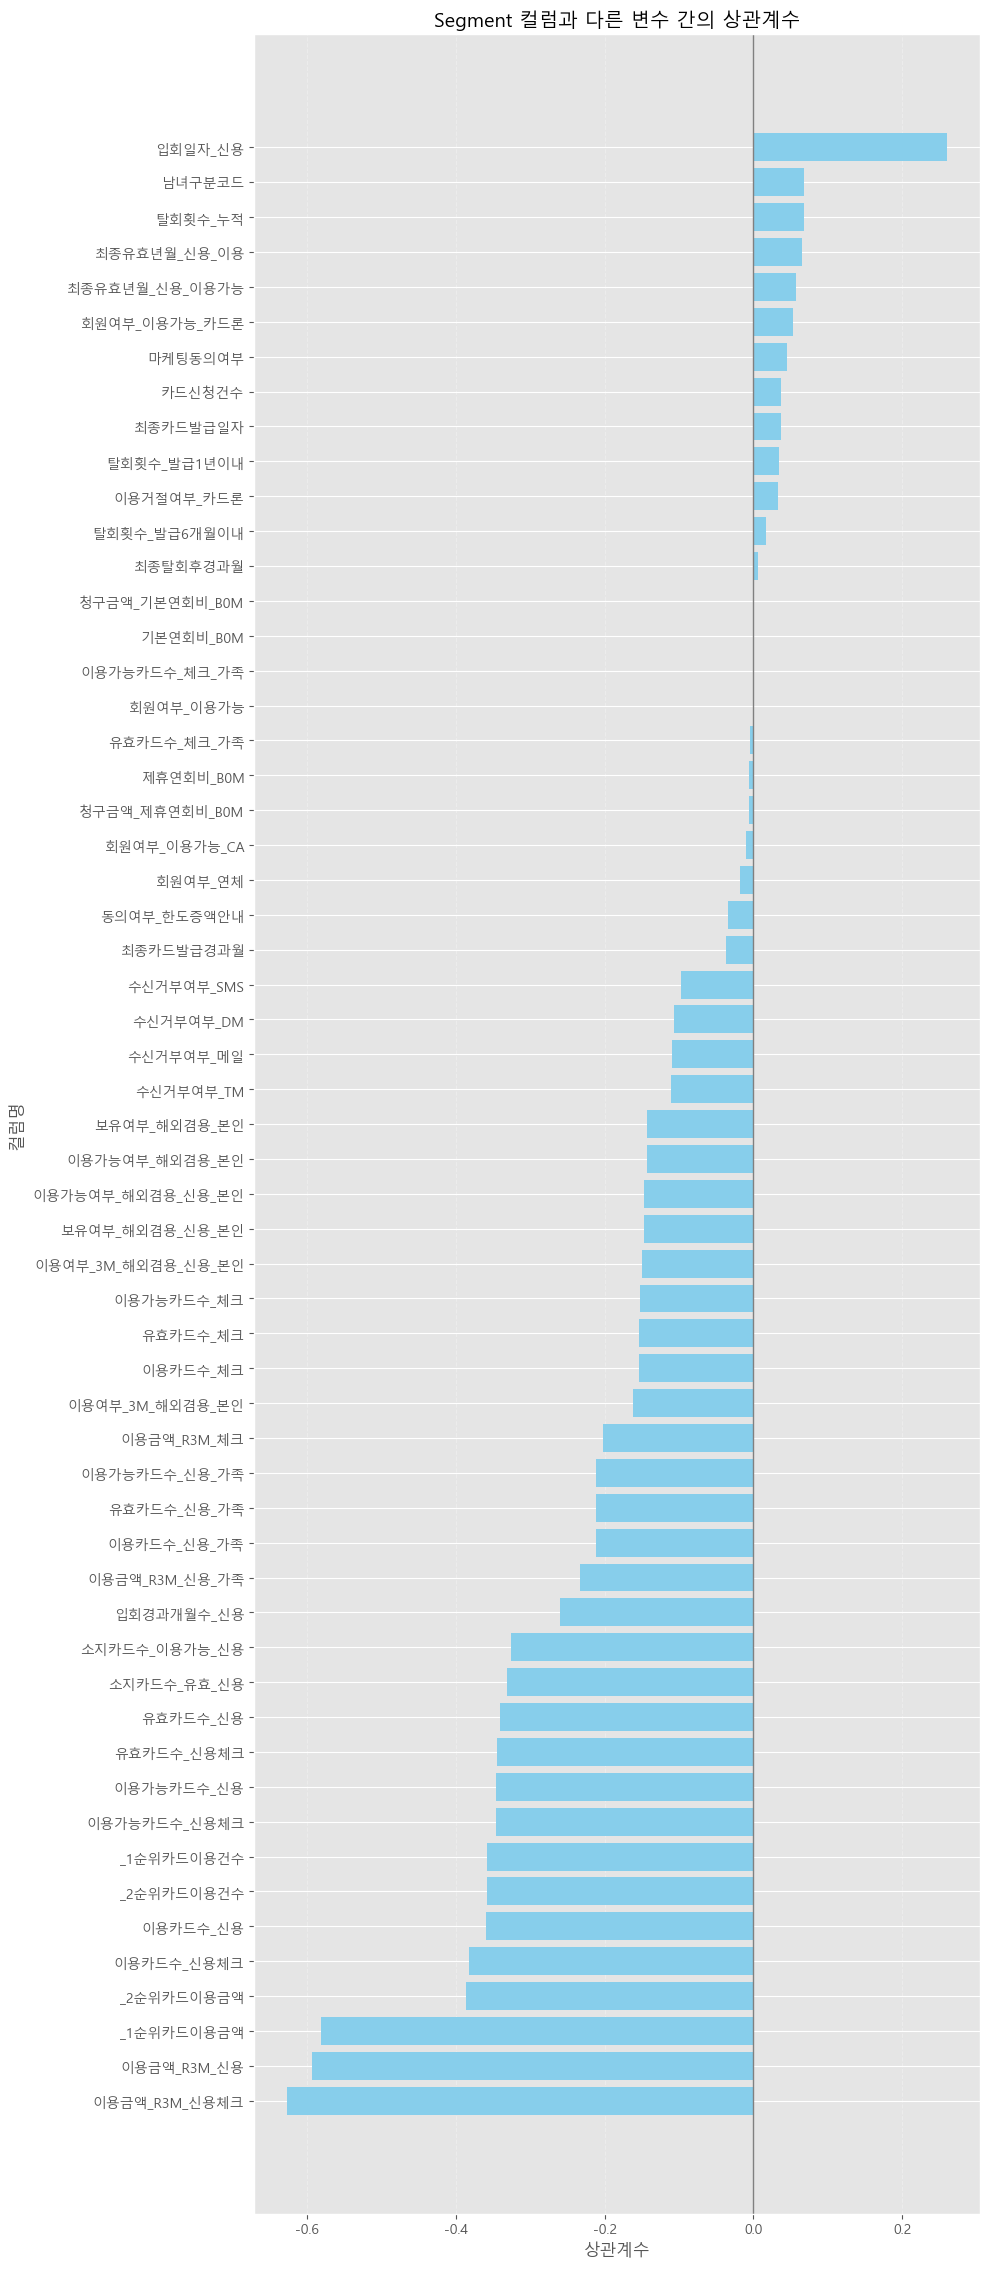

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 + 음수 기호 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 상관계수 기준으로 정렬
corr_df_sorted = corr_df.sort_values(by='상관계수')

# 시각화
plt.figure(figsize=(10, len(corr_df_sorted) * 0.4))  # 길이에 따라 크기 자동 조절
plt.barh(corr_df_sorted['컬럼명'], corr_df_sorted['상관계수'], color='skyblue')

plt.title("Segment 컬럼과 다른 변수 간의 상관계수", fontsize=14)
plt.xlabel("상관계수")
plt.ylabel("컬럼명")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.axvline(0, color='gray', linewidth=1)  # 기준선
plt.tight_layout()
plt.show()



In [32]:
중앙값 = corr_df['상관계수'].median()
print("상관계수 중앙값:", 중앙값)


상관계수 중앙값: -0.14337870401017888


In [33]:
corr_filtered = corr_df[abs(corr_df['상관계수']) >= 0.3]
print("선별된 변수 수:", len(corr_filtered))
display(corr_filtered)

선별된 변수 수: 14


,컬럼명,상관계수
0,이용금액_R3M_신용체크,-0.626634
1,이용금액_R3M_신용,-0.593124
2,_1순위카드이용금액,-0.581480
3,_2순위카드이용금액,-0.385806
4,이용카드수_신용체크,-0.382642
5,이용카드수_신용,-0.360037
6,_2순위카드이용건수,-0.358088
7,_1순위카드이용건수,-0.357563
8,이용가능카드수_신용체크,-0.346455
9,이용가능카드수_신용,-0.345393


In [34]:
# 1. 상관계수 기준으로 변수 필터링
corr_filtered = corr_df[abs(corr_df['상관계수']) >= 0.3]
selected_cols = corr_filtered['컬럼명'].tolist()

# 2. 선택된 컬럼 + segment 포함된 데이터프레임 만들기
selected_df = clean_df[selected_cols + [segment_col]]

# 3. 저장 경로 설정
import os
output_dir = "C:/Users/HR/Desktop/workspace/파이널프로젝트"
output_path = os.path.join(output_dir, "segment_회원정보_상관계수_0.3이상.csv")

# 4. 저장
selected_df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"저장 완료: {output_path}")


저장 완료: C:/Users/HR/Desktop/workspace/파이널프로젝트\segment_회원정보_상관계수_0.3이상.csv
